In [10]:
import seaborn as sns
import os
import networkx as nx
from pprint import pprint
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from grave import plot_network
basedir = '../results'

def giant_component(g: nx.Graph) -> nx.Graph:
    return nx.subgraph(g, max(nx.connected_components(g), key=len))


In [15]:
##Read all the graphs
graphs = []
for d in os.listdir(basedir):
    for f in os.listdir(f'{basedir}/{d}'):
        g = giant_component(nx.read_graphml(f'{basedir}/{d}/{f}'))
        graphs.append((d,f,g))


Robustness Analysis

In [14]:
def random_robustness(G, steps=10, runs=1):
    y = np.zeros(shape=(steps, runs+1))
    # BCC = G.subgraph(max(nx.connected_components(G), key=len))+
    xs = np.linspace(0, 1, steps, endpoint=False)
    y[:,0] = xs
    to_rem = (xs*len(G)).astype(int)
    for j in range(runs):
        for i, x in enumerate(to_rem):
            G_copy = G.copy()
            for n in random.sample(list(G_copy.nodes()), x):
                G_copy.remove_node(n)
            try:
                GC = max(nx.connected_components(G_copy), key=len)
                metric = len(GC)/len(G_copy)
            except ValueError:
                metric = 0/len(G_copy)
            y[i, j+1] = metric
            #print(f"Removed {int(xs)} nodes, G={len(G_copy)}, {len(GC)}")
        del G_copy
    return y


In [16]:
robustness = []
for (d,f,g) in graphs:
    area, lamb, radius, x, y = d.split('_')
    time, random_seed, topo_strategy, gw_strategy, runid = f.split('.')[0].split('_')
    rob = random_robustness(g)
    for r in rob:
        robust = {}
        robust['fraction'] = r[0]
        robust['value'] = r[1]
        robust['lamb'] = lamb
        robust['topo_strategy'] = topo_strategy
        robust['time'] = time
        robust['run'] = runid
        robust['area'] = area
        robustness.append(robust)
rdf = pd.DataFrame(robustness)


In [19]:
sns.relplot(data=rdf, x='fraction', y='value', hue='topo_strategy', kind='line', row='dataset')

ValueError: Could not interpret value `dataset` for parameter `row`

Graph plotting

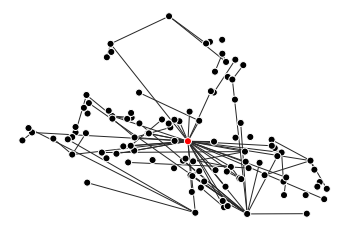

In [56]:
def layout(graph):
    pos_x = nx.get_node_attributes(graph, 'x')
    pos_y = nx.get_node_attributes(graph, 'y')
    return {n: (pos_x[n], pos_y[n]) for n in pos_x}

def nodest(node_attribute):
    if 'type' in node_attribute:
        return {'color':  'red'}
    else:
        return {'color': 'black'}
#print(graphs[0].nodes(data=True))
#print(df)
for id in df[(df.topo_strategy=='SimpleBackhaul') & (df.run=='1') & (df.time=='16473552749')].index.values:
    plot_network(graphs[id], layout=layout, node_style=nodest)


Analysis on more simple metrics

In [8]:
data = []
for (d,f,g) in graphs:
    measures = {}
    area, lamb, radius, x, y = d.split('_')
    time, random_seed, topo_strategy, gw_strategy, runid = f.split('.')[0].split('_')
    measures['run'] = runid
    measures['nodes'] = len(g)
    measures['edges'] = len(g.edges())    
    measures['diameter'] = nx.diameter(giant_component(g))
    measures['area'] = area
    measures['lamb'] = lamb
    measures['topo_strategy'] = topo_strategy
    measures['gw_strategy'] = gw_strategy
    measures['time'] = time
    measures['seed'] = random_seed
    data.append(measures)
        
df = pd.DataFrame(data)


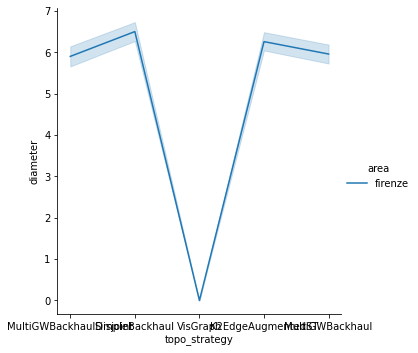

In [9]:
sns.relplot(data=df, x='topo_strategy', y='diameter', kind='line', hue='area')

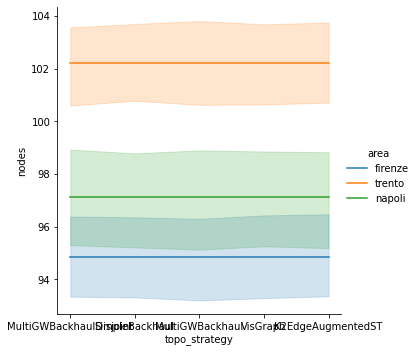

In [5]:
sns.relplot(data=df, x='topo_strategy', y='nodes', kind='line', hue='area')

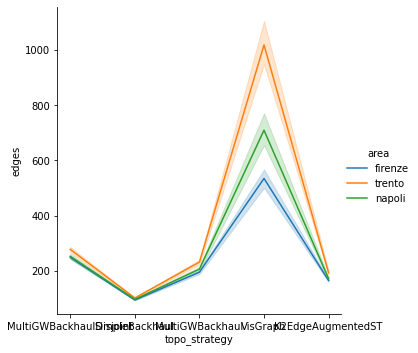

In [6]:
sns.relplot(data=df, x='topo_strategy', y='edges', kind='line', hue='area')
